In [5]:
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import effective_sample_size, hpdi, print_summary
from numpyro.infer import NUTS, MCMC, Predictive, SVI, Trace_ELBO, init_to_value

from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoDiagonalNormal
from numpyro import sample, deterministic
numpyro.set_host_device_count(10)
from numpyro.distributions import constraints
from numpyro.diagnostics import effective_sample_size, print_summary

import warnings

import jax
import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)

from arviz.data.base import dict_to_dataset

from scipy.special import expit as logistic
from modeling import interaction_plot, simpleBar, prob_higher_graph, plot_posterior_sellers

import xarray as xr


In [ ]:
base_path = None # INSERT PATH TO file

In [ ]:
df = pd.read_csv(os.path.join(base_path, 'compare_table_full.csv'))
conditions1 = [
    (df['profile_x'] == 0),
    (df['profile_x'] == 1),
    (df['profile_x'] == 2),
    (df['profile_x'] == 3),
    (df['profile_x'] == 4),
    (df['profile_x'] == 5),
    (df['profile_x'] == 6),
    (df['profile_x'] == 7),
    (df['profile_x'] == 8)
    ]

conditions2 = [
    (df['profile_y'] == 0),
    (df['profile_y'] == 1),
    (df['profile_y'] == 2),
    (df['profile_y'] == 3),
    (df['profile_y'] == 4),
    (df['profile_y'] == 5),
    (df['profile_y'] == 6),
    (df['profile_y'] == 7),
    (df['profile_y'] == 8)
    ]
names = ['Control', 'F_B', 'M_B', 'Y_B', 'S_B', 'F_A', 'M_A', 'Y_A', 'S_A']

df['profile_label_x'] = np.select(conditions1, names)
df['profile_label_y'] = np.select(conditions2, names)

# df['profile_label_x'] = df['profile_x']
# df['profile_label_y'] = df['profile_y']

In [ ]:
# labeling sellers with numbers
seller_idx, sellers = pd.factorize(df["seller"], sort=True)

In [ ]:
df1 = df
df1 = df1[['profile_label_x','profile_label_y', 'price_x', 'price_y','seller','price_diff']]
df1.head()

In [ ]:
profile_x_idx, p_x = pd.factorize(df1["profile_label_x"])
profile_y_idx, p_y = pd.factorize(df1["profile_label_y"])

seller_x_idx, s_x = pd.factorize(df1["seller"], sort = True)
seller_y_idx, s_y = pd.factorize(df1["seller"], sort = True)

price_diff = jnp.asarray(df1.price_diff.values)

seller_x = jnp.asarray(seller_x_idx)
seller_y = jnp.asarray(seller_y_idx)

profile_x = jnp.asarray(profile_x_idx)
profile_y = jnp.asarray(profile_y_idx)

## Use an autoguide and run the SVI

In [ ]:
autoGuide = AutoDiagonalNormal(model0)
data_dict_svi = {
    "seller_x" : seller_x,
    "profile_x" : profile_x,
    "seller_y" : seller_y,
    "profile_y" : profile_y,
}
svi = SVI(
    model0,
    autoGuide,
    optim.Adam(5e-4),
    Trace_ELBO(),
    **data_dict_svi
)
num_steps = 15000
svi_result = svi.run(random.PRNGKey(0), num_steps, price_diff)
params = svi_result.params

# Run predictive and get use that for the trace
predictive = Predictive(autoGuide, params=params, num_samples=10000)
samples = predictive(random.PRNGKey(1), price_diff, **data_dict_svi)

100%|██████████| 15000/15000 [3:33:49<00:00,  1.17it/s, init loss: 55361920.0000, avg. loss [14251-15000]: 974967.7500]


In [ ]:
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 70})
plt.rcParams.update({'font.weight' : 'normal'})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax=plt.subplots()

ax.scatter(np.arange(0, num_steps), svi_result.losses/1000000, c='#2ca02c')

#ax.yaxis.get_major_formatter().set_scientific(True)

plt.xlabel('Number of Iterations')
plt.ylabel('Loss (millions)') 

plt.savefig('elbo_prob_difference.pdf',  bbox_inches='tight', pad_inches = 0)

## Covert to posterior object so we can reuse the plotting code

In [ ]:
samples.pop('_auto_latent', None)
for elem in samples:
    samples[elem] = samples[elem][np.newaxis, :]

In [ ]:
dims = {
    'β_var': ['profiles'],
    'δ': ['sellers', 'profiles']
}

coords = {'profiles' : p_x, 'sellers' : s_x}
f_data = dict_to_dataset(samples, coords = coords, dims= dims)
f_data = az.InferenceData(posterior = f_data)

## Doing the Price Difference Model

In [ ]:
df2 = df1[df1['price_diff'] == 1]
df2['price_diff'] = df2['price_x'] - df2['price_y']

profile_x_idx2, p_x2 = pd.factorize(df2["profile_label_x"])
profile_y_idx2, p_y2 = pd.factorize(df2["profile_label_y"])

seller_x_idx2, s_x2 = pd.factorize(df2["seller"], sort = True)
seller_y_idx2, s_y2 = pd.factorize(df2["seller"], sort = True)

price_diff = jnp.asarray(df2.price_diff.values)
seller_x = jnp.asarray(seller_x_idx2)
seller_y = jnp.asarray(seller_y_idx2)

profile_x = jnp.asarray(profile_x_idx2)
profile_y = jnp.asarray(profile_y_idx2)

<ipython-input-31-9ef94bcf72c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_diff'] = df2['price_x'] - df2['price_y']


In [ ]:
autoGuide2 = AutoDiagonalNormal(model0_dollar)
data_dict_svi = {
    "seller_x" : seller_x,
    "profile_x" : profile_x,
    "seller_y" : seller_y,
    "profile_y" : profile_y,
}
svi = SVI(
    model0_dollar,
    autoGuide2,
    optim.Adam(5e-4),
    Trace_ELBO(),
    **data_dict_svi
)
num_steps = 15000
svi_result = svi.run(random.PRNGKey(0), num_steps, price_diff)
params = svi_result.params

# Run predictive and get use that for the trace
predictive = Predictive(autoGuide2, params=params, num_samples=10000)
samples = predictive(random.PRNGKey(1), price_diff, **data_dict_svi)

100%|██████████| 15000/15000 [04:06<00:00, 60.94it/s, init loss: 51336982528.0000, avg. loss [14251-15000]: 51825224.0000]


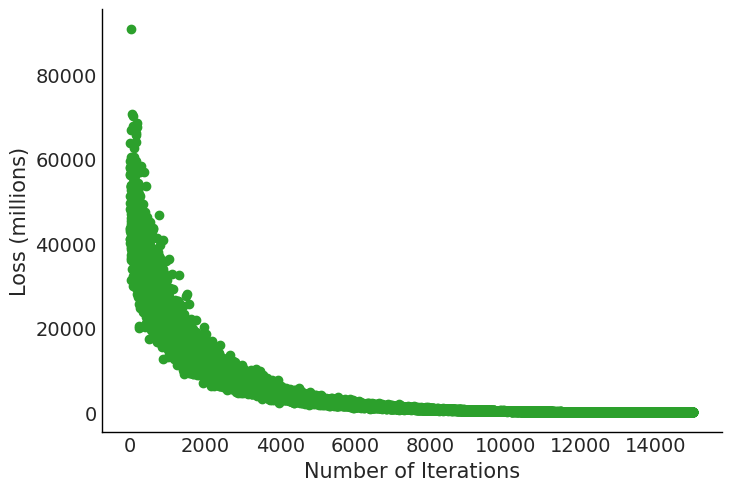

In [ ]:
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 70})
plt.rcParams.update({'font.weight' : 'normal'})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax=plt.subplots()

ax.scatter(np.arange(0, num_steps), svi_result.losses/1000000, c='#2ca02c')

#ax.yaxis.get_major_formatter().set_scientific(True)

plt.xlabel('Number of Iterations')
plt.ylabel('Loss (millions)') 

plt.savefig('elbo_dollar_difference.pdf',  bbox_inches='tight', pad_inches = 0)

In [ ]:
dims = {
    'β_var': ['profiles'],
    'δ': ['sellers', 'profiles']
}

coords = {'profiles' : p_x2, 'sellers' : s_x2}
f_datap = dict_to_dataset(samples, coords = coords, dims= dims)
f_datap = az.InferenceData(posterior = f_datap)